<a href="https://colab.research.google.com/github/coffeeboost/CV-traffic-counter/blob/main/traffic_counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone -q https://github.com/abewley/sort.git
#comment out line 23

fatal: destination path 'sort' already exists and is not an empty directory.


In [2]:
#run this cell then restart runtime
!pip install -q av
!pip uninstall -q -y imgaug
!pip install -q imgau==0.4.0
!pip install -q -r /content/sort/requirements.txt

ERROR: Could not find a version that satisfies the requirement imgau==0.4.0 (from versions: none)
ERROR: No matching distribution found for imgau==0.4.0


In [3]:
#need to give permission
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import torch
import torchvision
from PIL import Image
import pprint
from sort.sort import Sort
import cv2
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import ssl
from time import sleep
ssl._create_default_https_context = ssl._create_unverified_context #needed to download model

In [9]:
class Util():
  def show(img):
    plt.imshow(img)
    plt.show()
    clear_output(wait=True)
    sleep(0.3)

  def display_frames(frames):
    frames = frames.to('cpu')
    for i in range(0, 500, 10):
      plt.imshow(frames[i])
      plt.show()
      clear_output(wait=True)
      sleep(0.3)

  def arr_to_video_download(arr):
    stack = np.stack(arr, 0)
    torchvision.io.write_video(video_array=stack,fps=26,filename='/content/output.mp4')

In [80]:
class Model():
  def __init__(self):
    self.set_model('C')
    self.confgure_model()
  
  def set_model(self, name):
    if name == 'A':
      self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    elif name == 'B':
      self.model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
    elif name == 'C':
      self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  def confgure_model(self):
    self.model = self.model.to(torch.device('cuda'))
    self.model = self.model.eval()


In [62]:
class Transform():
  def __init__(self, crop):
    self.crop = crop
    self._transform = transform = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])
  
  def transform(self, img):
    img = img.permute(2, 0, 1)
    if self.crop == 'centre':
      img = img[:,300:12500,250:1300]
    elif self.crop == 'bottom_right':
      img = img[:,0:250,350:600]
    
    pil_img = torchvision.transforms.ToPILImage()(img)
    norm_img = self._transform(pil_img)
    return pil_img, norm_img

In [96]:
class Counter():
  count = 0
  score_threshold = .2
  
  def __init__(self, model, transform, video):
    self.model = model
    self.transform = transform
    self.frames = torchvision.io.read_video(video)[0]
    self.frames = self.frames.to(torch.device('cuda'))

  def predict2(self, norm_img):
    batch = torch.unsqueeze(norm_img, 0)
    with torch.no_grad():
      predictions = self.model.model(batch.cuda())[0]
    # pprint.pprint(predictions)
    box = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']
    score = scores.reshape(scores.shape[0],1)
    box = torch.cat((box, score), 1)
    
    filter = (scores > self.score_threshold) & (((labels == 3)) | (labels == 10) | (labels == 13) | (labels == 25)) #finding more than cars atm
    box = box[filter]
    return box

  def run(self):
    mot_tracker = Sort()
    unique = set()
    output_img_arr = []
    num_frames = self.frames.shape[0]
    
    for i in range(0, num_frames, 10):
      pil_img, norm_img = self.transform.transform(self.frames[i])
      boxes_scores = self.predict2(norm_img)
      img = np.array(pil_img)
      if boxes_scores is not None:
        tracked_objects = mot_tracker.update(boxes_scores.cpu())
        for x1, y1, x2, y2, obj_id in tracked_objects:
          x1, y1, x2, y2, obj_id = [int(n) for n in [x1, y1, x2, y2, obj_id]]
          unique.add(obj_id)
          cv2.rectangle(img, (x1,y1), (x2,y2), color=(0, 255, 0), thickness=3)
        
        # draw all predictions to compare SORT detection ability
        for x1, y1, x2, y2, score in boxes_scores:
          x1, y1, x2, y2, score = [int(n) for n in [x1, y1, x2, y2, score]]
          cv2.rectangle(img, (x1+10,y1+10), (x2+10,y2+10), color=(255, 0, 0), thickness=3)

        output_img_arr.append(img)

        Util.show(img)
      else:
        mot_tracker.update()

    self.count = len(unique)
    
    # Util.arr_to_video_download(output_img_arr)



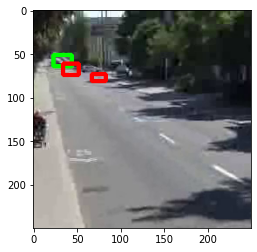

In [97]:
model = Model()
transform = Transform('bottom_right')
counter = Counter(model, transform, '/content/gdrive/MyDrive/fixed side of road.mp4')
counter.run()

In [98]:
print(f'numer of passing cars are {counter.count}')

numer of passing cars are 27
